# Chapter 9. Recurrent Neural Network


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## Chapter 9.1 Working with Sequences

In [6]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2
        
        
    def get_dataloader(self, train):
        features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
        self.features = torch.stack(features, 1)
        self.labels = self.x[self.tau:].reshape((-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
        

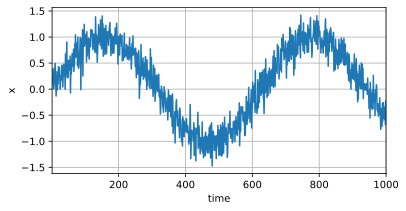

In [8]:
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

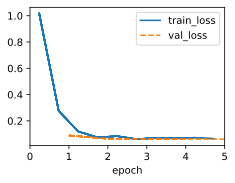

In [9]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

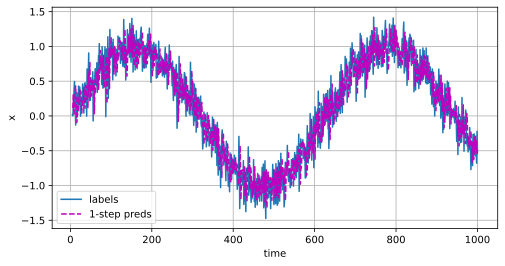

In [11]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(data.time[data.tau:], 
         [data.labels, onestep_preds], 
         'time', 'x',
         legend=['labels', '1-step preds'],
         figsize=(8, 4)
        )

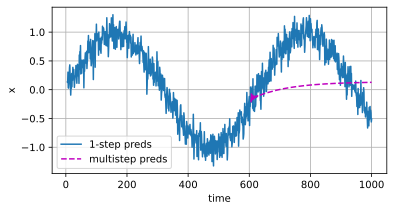

In [12]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x

for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(
        multistep_preds[i - data.tau:i].reshape((1, -1))
    )

multistep_preds = multistep_preds.detach().numpy()

d2l.plot(
    [data.time[data.tau:], data.time[data.num_train + data.tau:]],
    [onestep_preds, multistep_preds[data.num_train + data.tau:]],
    'time', 'x',
    legend=['1-step preds', 'multistep preds'], figsize=(6, 3)
)

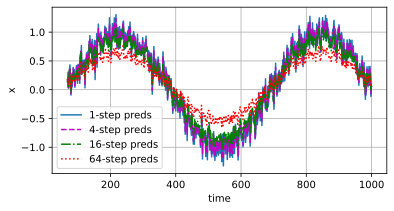

In [13]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
        
    for i in range(k):
        preds = model(torch.stack(features[i : i+data.tau], 1))
        features.append(preds.reshape(-1))
        
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])

d2l.plot(
    data.time[data.tau + steps[-1] -1 :],
    [preds[k - 1].detach().numpy() for k in steps],
    'time', 'x',
    legend=[f'{k}-step preds' for k in steps], 
    figsize=(6, 3)
)

## Chapter 9.2 Converting Raw Text into Sequence Data

In [14]:
import collections
import random
import re
import torch
from d2l import torch as d2l

In [44]:
class TimeMachine(d2l.DataModule):
    """ The Time Machine Book """
    def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
        super(d2l.TimeMachine, self).__init__()
        self.save_hyperparameters()
        corpus, self.vocab = self.build(self._download())
        array = torch.tensor([corpus[i:i+num_steps+1] 
                              for i in range(len(corpus)-num_steps)])
        self.X, self.Y = array[:, :-1], array[:, 1:]
        
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(
            self.num_train, self.num_train + self.num_val
        )
        return self.get_tensorloader([self.X, self.Y], train, idx)
    
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt',
                                self.root, '090b5e7e70c295757f55df93cb0a180b9691891a')
        
        with open(fname) as f:
            return f.read()
        
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()
    
    def _tokenize(self, text):
        return list(text)
    
    def build(self, raw_text, vocab=None):
        tokens = self._tokenize(self._preprocess(raw_text))
        if vocab is None:
            vocab = Vocab(tokens)
        corpus = [vocab[token] for token in tokens]
        return corpus, vocab

In [30]:
data = TimeMachine()
raw_text = data._download()
raw_text[:200]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Traveller (for so it will be convenient to speak of him)\nwas expounding a recondite matter to us. His grey eyes shone and\ntwinkled, and his usu'

In [24]:
text = data._preprocess(raw_text)
text[:300]

'the time machine by h g wells i the time traveller for so it will be convenient to speak of him was expounding a recondite matter to us his grey eyes shone and twinkled and his usually pale face was flushed and animated the fire burned brightly and the soft radiance of the incandescent lights in the'

In [25]:
tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

In [26]:
class Vocab:
    """ Vocabulary for text """
    
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
            
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        
        self.idx_to_token = list(sorted(set(
            ['<unk>'] + 
            reserved_tokens + 
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']
        
        

In [28]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


In [31]:
corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

In [32]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

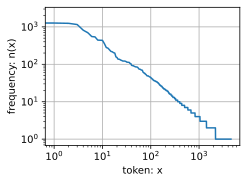

In [33]:
freqs = [freq for token, freq in vocab.token_freqs]

d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [34]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [35]:
trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:]
)]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

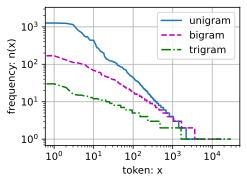

In [36]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

d2l.plot([freqs, bigram_freqs, trigram_freqs], 
        xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram']
        )

## Chapter 9.3 Language Models

In [47]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)

for X, Y in data.train_dataloader():
    print('X:', X, '\nY:', Y)
    break

X: tensor([[ 2, 20,  0, 24,  6,  0, 20,  9, 16, 22],
        [22, 20, 15,  6, 20, 20,  0, 14, 16, 23]]) 
Y: tensor([[20,  0, 24,  6,  0, 20,  9, 16, 22, 13],
        [20, 15,  6, 20, 20,  0, 14, 16, 23,  6]])


## Chpater 9.4 Recurrent Neural Networks

In [48]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[ 1.6271,  1.1149,  1.4287,  0.6329],
        [ 0.5267, -1.3890, -1.5029, -1.7376],
        [-0.7297, -1.0616, -2.1459, -0.2345]])

In [50]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[ 1.6271,  1.1149,  1.4287,  0.6329],
        [ 0.5267, -1.3890, -1.5029, -1.7376],
        [-0.7297, -1.0616, -2.1459, -0.2345]])

## Chapter 9.5 RNN from Scratch

In [51]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [56]:
class RNNScratch(d2l.Module):
    """The RNN model implemented from scratch."""
    
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(
            torch.zeros(num_hiddens))
        
    def forward(self, inputs, state=None):
        if state is None:
            state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
        else:
            state, = state
        
        outputs = []
        for X in inputs:
            state = torch.tanh(torch.matmul(X, self.W_xh) +
                                  torch.matmul(state, self.W_hh) +
                                  self.b_h)
            outputs.append(state)
        return outputs, state
    
        

In [60]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [66]:
def check_len(a, n):
    assert len(a) == n, f'list length {len(a)} != exptected length {n}'
    
def check_shape(a, shape):
    assert a.shape == shape, f'tensor shape {a.shape} != expected shape {shape}'
    

In [67]:
check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

In [82]:
class RNNLMScratch(d2l.Classifier):
    """The RNN-based language model implemented from scratch."""
    
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
        
    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * 
            self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
        
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l
    
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
    
    def one_hot(self, X):
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)
    
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            
            if i < len(prefix) - 1:
                outputs.append(vocab[prefix[i + 1]])
            else:
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        
        return ''.join([vocab.idx_to_token[i] for i in outputs]) 
    

In [69]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [75]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

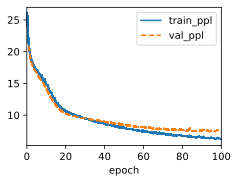

In [76]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [83]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)

model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it haswgzjawgzjawgzjawgzja'

## Chapter 9.6 Concise Implementation of RNN

In [84]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [85]:
class RNN(d2l.Module):
    """The RNN model implemented with high-level APIs."""
    
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)
        
    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [86]:
class RNNLM(d2l.RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs."""
    
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
        
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

In [87]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict('it has', 20, data.vocab)

'it hascicicicicicicicicici'

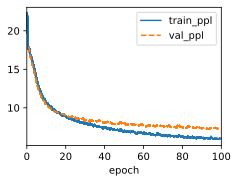

In [88]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [89]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has and the pere the th'